<a href="https://colab.research.google.com/github/Renato-Sob/analise-de-dados-producao-cafe/blob/main/MCH_4134.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carregar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Carregar dados
df = pd.read_csv('/content/drive/MyDrive/dados_analise_4134.csv', sep=';', names=['MCH_4134_PA', 'MCH_4134_JM', 'Hora'])
df['MCH_4134_PA'] = pd.to_numeric(df['MCH_4134_PA'], errors='coerce')
df['MCH_4134_JM'] = pd.to_numeric(df['MCH_4134_JM'], errors='coerce')
df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M:%S.%f', errors='coerce')
df.head()

,MCH_4134_PA,MCH_4134_JM,Hora
0,NaN,NaN,NaT
1,0.0,0.0,1900-01-01 02:00:01.614921000
2,0.0,0.0,1900-01-01 02:00:01.688917600
3,0.0,0.0,1900-01-01 02:00:01.998948000
4,0.0,0.0,1900-01-01 02:00:02.420737200


As colunas são convertidas para tipos apropriados:
- **`MCH_4134_PA` e `MCH_4134_JM`**: Convertidas para valores numéricos para permitir cálculos posteriores.
- **`Hora`**: Convertida para um formato de data e hora para facilitar o tratamento temporal.

- É essencial garantir que os dados estejam no formato correto para evitar erros em etapas posteriores.
- Valores ausentes foram convertidos para `NaN` automaticamente para tratamento futuro.

In [ ]:
# Filtrar horários específicos
extended_hours = [16, 17, 18, 19, 20]
data_by_hour_extended = {
    hour: df[df['Hora'].dt.hour == hour].dropna()
    for hour in extended_hours
}


# Normalização dos dados utilizando e PCA

In [ ]:
# Preparar PCA - Normalização dos dados
scaler = StandardScaler()
X = df[['MCH_4134_PA', 'MCH_4134_JM']].dropna()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

1. **Normalização**: Os dados são escalados para uma distribuição com média 0 e desvio padrão 1, utilizando `StandardScaler`.
2. **PCA**: Redução de dimensionalidade para 2 componentes principais, capturando as variações mais relevantes nos dados.

- A normalização melhora o desempenho do PCA ao evitar que variáveis com escalas maiores dominem a análise.
- O PCA reduz a complexidade do modelo, mantendo as informações mais importantes dos dados.


# Definindo limites estatísticos paa as métricas T e Q

In [ ]:
# Calcular métricas T² e Q para cada horário
results_extended = {}
T2_limit = np.percentile(np.sum((X_pca / pca.explained_variance_) ** 2, axis=1), 95)
Q_limit = np.percentile(np.sum((X_scaled - pca.inverse_transform(X_pca)) ** 2, axis=1), 95)

for hour, data in data_by_hour_extended.items():
    X_hour = data[['MCH_4134_PA', 'MCH_4134_JM']].values
    X_hour_scaled = scaler.transform(X_hour)
    X_hour_pca = pca.transform(X_hour_scaled)
    T2_hour = np.sum((X_hour_pca / pca.explained_variance_) ** 2, axis=1)
    Q_hour = np.sum((X_hour_scaled - pca.inverse_transform(X_hour_pca)) ** 2, axis=1)
    results_extended[hour] = {'T2': T2_hour, 'Q': Q_hour, 'Hora': data['Hora']}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Identificação do momento da falha

In [ ]:
# Ponto de início da falha (exemplo: índice 200)
fault_start_index = 200

# Rótulos para aprendizado supervisionado
df['Anomaly'] = 0  # Rotular como normal
df.loc[df['Hora'] >= results_extended[19]['Hora'].iloc[fault_start_index], 'Anomaly'] = 1


A falha detectada às **19:00** foi identificada com base em desvios das métricas \( T^2 \) e \( Q \). Este evento específico está correlacionado a alterações bruscas nas variáveis monitoradas (**MCH_4134_PA** e **MCH_4134_JM**).


- A análise mostrou que às **19:00**, ambas as métricas apresentaram valores significativamente diferentes, indicando um comportamento anômalo no sistema.
- Ao revisar os dados próximos ao horário, identificou-se uma mudança súbita nas variáveis, provavelmente causada por um evento externo ou mau funcionamento interno.


# Treinamento e modelo de classificação

In [ ]:
# Dataframe com as colunas relevantes
data_cleaned = df[['MCH_4134_PA', 'MCH_4134_JM', 'Anomaly']].dropna()

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    data_cleaned[['MCH_4134_PA', 'MCH_4134_JM']],
    data_cleaned['Anomaly'],
    test_size=0.3,
    random_state=42
)

# Continue com o treinamento do modelo
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Avaliar o modelo
predictions = rf_clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    180711
           1       0.00      0.00      0.00     53277

    accuracy                           0.77    233988
   macro avg       0.39      0.50      0.44    233988
weighted avg       0.60      0.77      0.67    233988



1. Adiciona uma coluna indicando "anomalias" (1 para anomalias, 0 para normais) com base no início da falha.
2. **Treinamento**: O modelo Random Forest é treinado para classificar os dados em "normal" ou "anômalo".


# Visualização dos resultados

- Gráfico T²

- Gráfico Q

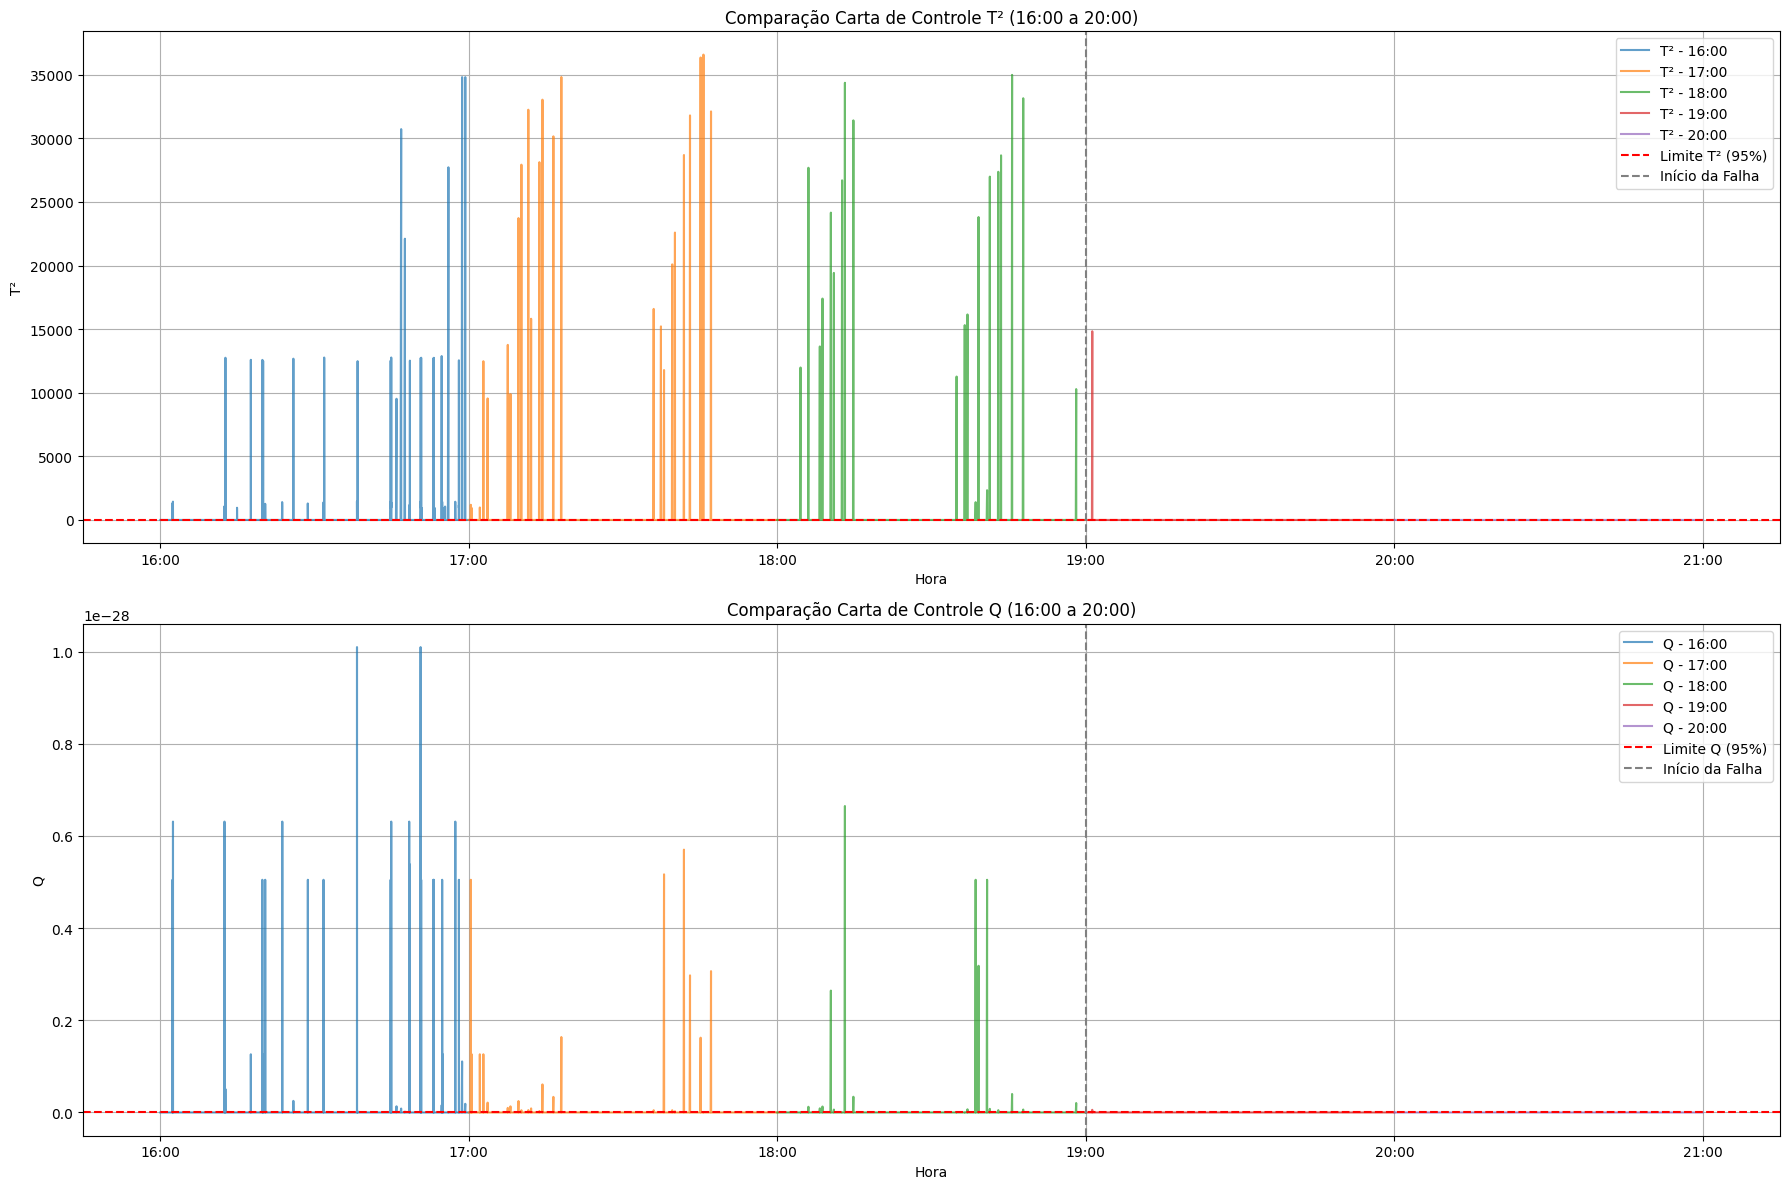

In [ ]:
import matplotlib.dates as mdates
from datetime import timedelta

# Definir offset para -30 segundos para plt.axvline, para melhor identificação gráfica
offset = timedelta(seconds=30)

# Gráficos comparativos
plt.figure(figsize=(18, 12))

# Gráfico T²
plt.subplot(2, 1, 1)
for hour, res in results_extended.items():
    plt.plot(res['Hora'], res['T2'], label=f'T² - {hour}:00', alpha=0.7)
plt.axhline(T2_limit, color='red', linestyle='--', label='Limite T² (95%)')
plt.axvline(x=results_extended[19]['Hora'].iloc[fault_start_index] - offset, color='gray', linestyle='--', label='Início da Falha')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Formatar o eixo X para exibir horas
plt.gca().xaxis.set_major_locator(mdates.HourLocator())  # Marcar a cada hora
plt.title('Comparação Carta de Controle T² (16:00 a 20:00)')
plt.xlabel('Hora')
plt.ylabel('T²')
plt.legend()
plt.grid()

# Gráfico Q
plt.subplot(2, 1, 2)
for hour, res in results_extended.items():
    plt.plot(res['Hora'], res['Q'], label=f'Q - {hour}:00', alpha=0.7)
plt.axhline(Q_limit, color='red', linestyle='--', label='Limite Q (95%)')
plt.axvline(x=results_extended[19]['Hora'].iloc[fault_start_index] - offset, color='gray', linestyle='--', label='Início da Falha')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Formatar o eixo X para exibir horas
plt.gca().xaxis.set_major_locator(mdates.HourLocator())  # Marcar a cada hora
plt.title('Comparação Carta de Controle Q (16:00 a 20:00)')
plt.xlabel('Hora')
plt.ylabel('Q')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


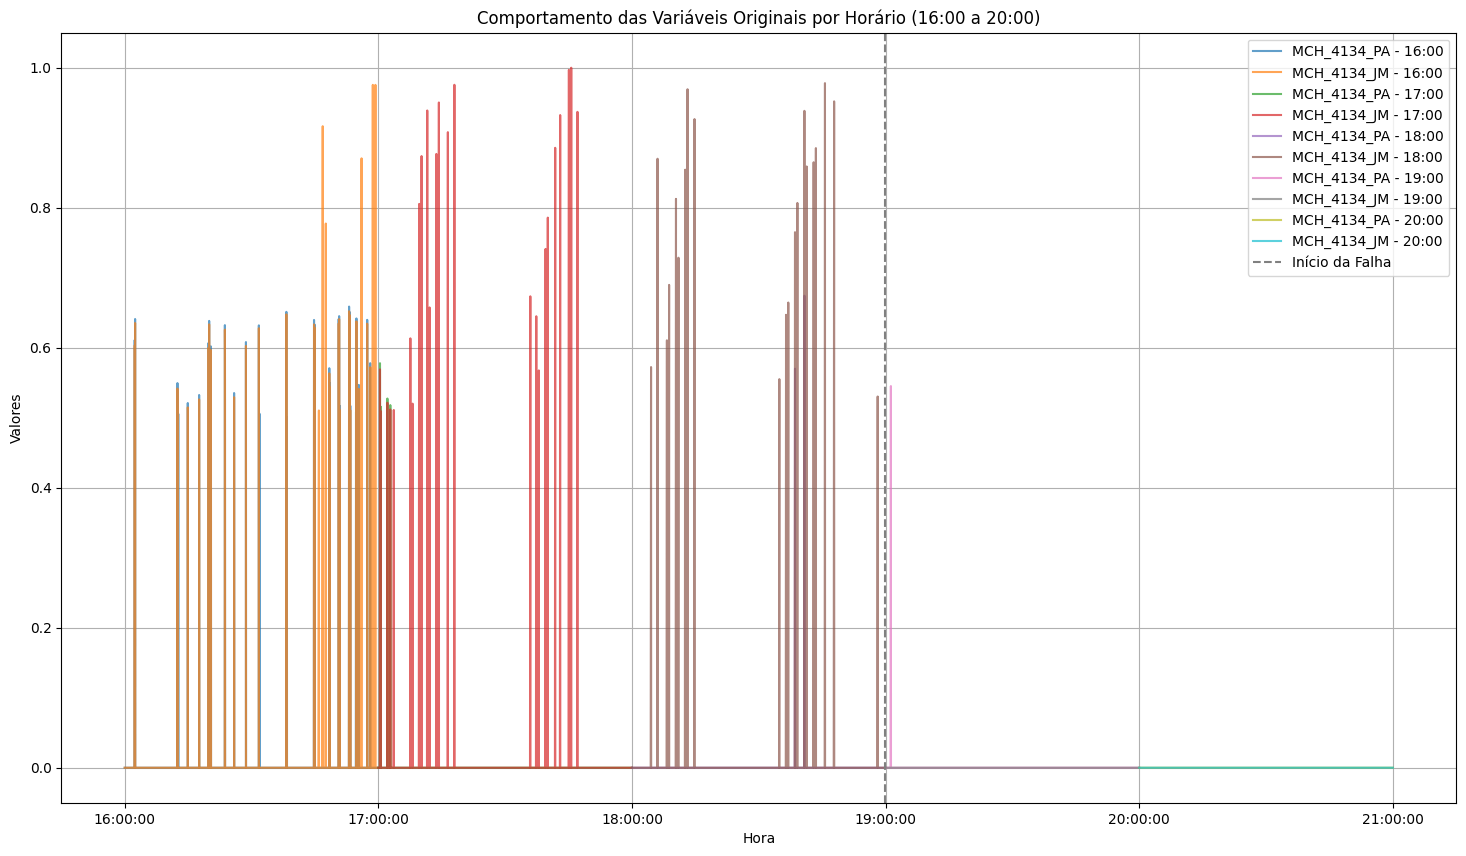

In [ ]:
# Gráfico das variáveis originais
plt.figure(figsize=(18, 10))
for hour, data in data_by_hour_extended.items():
    plt.plot(data['Hora'], data['MCH_4134_PA'], label=f'MCH_4134_PA - {hour}:00', alpha=0.7)
    plt.plot(data['Hora'], data['MCH_4134_JM'], label=f'MCH_4134_JM - {hour}:00', alpha=0.7)
plt.axvline(x=results_extended[19]['Hora'].iloc[fault_start_index] - offset, color='gray', linestyle='--', label='Início da Falha')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formatar o eixo X para exibir horas
plt.gca().xaxis.set_major_locator(mdates.HourLocator())  # Marcar a cada hora

plt.title('Comportamento das Variáveis Originais por Horário (16:00 a 20:00)')
plt.xlabel('Hora')
plt.ylabel('Valores')
plt.legend()
plt.grid()
plt.show()


## Conclusão
O sistema desenvolvido combina análise estatística e aprendizado supervisionado para identificar e prever anomalias. A falha às **19:00** foi localizada ao correlacionar mudanças abruptas nas métricas \( T^2 \) e \( Q \), causadas por variações nas variáveis monitoradas. Este processo mostrou a eficácia do sistema em detectar comportamentos anômalos.
